<a href="https://colab.research.google.com/github/siddsuresh97/prep_tutorial/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Download files - run this only once

import zipfile
!wget --no-check-certificate \
    "https://github.com/siddsuresh97/prep_tutorial/archive/refs/heads/main.zip" \
    -O "/tmp/prep_cnn_psychophysics.zip"


zip_ref = zipfile.ZipFile('/tmp/prep_cnn_psychophysics.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-07-13 01:59:29--  https://github.com/siddsuresh97/prep_tutorial/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/siddsuresh97/prep_tutorial/zip/refs/heads/main [following]
--2022-07-13 01:59:30--  https://codeload.github.com/siddsuresh97/prep_tutorial/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106011573 (101M) [application/zip]
Saving to: ‘/tmp/prep_cnn_psychophysics.zip’

/tmp/prep_cnn_psych 100%[===================>] 101.10M  17.3MB/s    in 6.5s    

2022-07-13 01:59:36 (15.7 MB/s) - ‘/tmp/prep_cnn_psychophysics.zip’ saved [106011573/106011573]



## If restart runtime

In [35]:
#@title imports
!pip install --upgrade matplotlib
!pip install deepdish -q
!pip install ipdb -q

import logging
import random
import ast
import zipfile
import gc
import os
import numpy as np
import time
import pickle
from datetime import datetime
import deepdish as dd

from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

import os
from turtle import title
import ipdb
import pickle
import numpy as np
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import matplotlib as mpl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 33.9 MB/s 
     |████████████████████████████████| 944 kB 58.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
BASE_DIR = '/tmp/prep_tutorial-main'
RESULTS_DIR = os.path.join(BASE_DIR, "results/")
BATCH_SIZE = 512
INTERMEDIATE_LAYER_NAMES = ['avg_pool', 'pool1_pool']


In [4]:
#@title helper functions - intermediate layer features


def store_dataset_fnames(intermediate_layer_names, dataset_dir, batch_size, stim_type, features_dir):
    # Stores filenames of stimuli in a pickle file
    # Fnames of stimuli contain metadata about labels
    # Only one intermediate layer is used because the fnames are same regardless of the intermediate layer
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)
    if not os.path.exists(features_dir):
        os.makedirs(features_dir)
    for layer in intermediate_layer_names[0]:
        generator = datagen.flow_from_directory(dataset_dir, shuffle = False, batch_size = batch_size)
        filenames = generator.filenames
        fname_dict = {'fnames':filenames}
        pickle.dump( fname_dict, open(os.path.join(features_dir,"filenames_{}.p".format(stim_type)), "wb" ))  
    logging.info(datetime.now().strftime("%H:%M:%S"))


def store_intermediate_layer_features(model_name, intermediate_layer_names, dataset_dir, batch_size, stim_type, features_dir):
    for layer in intermediate_layer_names:
        logging.info('------------------------------- {} ----------------------------'.format(layer))
        if model_name == 'resnet50':
            datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)
        else:
            logging.error('Models apart from resnet50 not implemented')
        generator = datagen.flow_from_directory(dataset_dir, shuffle = False, batch_size = batch_size, target_size = (224, 224))
        len = generator.n
        batches = np.ceil(len/batch_size)
        extract_and_store(model_name, 1, layer, generator, features_dir, stim_type, batches)
        extract_and_store(model_name, 2, layer, generator, features_dir, stim_type, batches)
    return


def extract_intermediate_layer_representations(model_name, intermediate_layer_names, dataset_base_dir, batch_size, stim_type, features_base_dir, conditions, exp_name):
    """
    This function extracts and stores intermediate layer representations given a model
    and a dataset   
    """
    if exp_name == '1a':
        stim_name = 'random_stim'
    elif exp_name == '1b':
        stim_name = 'test_stim' 
    else:
        logging.error('Only Exp 1a, 1b implemented')

    # condition is set size if exp is 1a or 1b, otherwise it is color diveristy
    for condition in conditions:
        if exp_name in ['1a', '1b']:
            dataset_dir = os.path.join(dataset_base_dir, '{}_generated_stimuli'.format(condition), stim_name)
            features_dir = os.path.join(features_base_dir, 'set_size_{}'.format(condition))
        elif exp_name in ['2a']:
            stim_type = condition
            dataset_dir = os.path.join(dataset_base_dir, condition)
            features_dir = os.path.join(features_base_dir)
        else:
            logging.error('Only 1a, 1b, 2a activation extraction implemented')
        store_dataset_fnames(intermediate_layer_names, dataset_dir, batch_size, stim_type, features_dir)
        start = time.time()
        store_intermediate_layer_features(model_name, intermediate_layer_names, dataset_dir, batch_size, stim_type, features_dir)
        logging.info('Total time to extract intermediate layer reprsentations (in seconds): {}'.format(time.time()-start))


def extract_and_store(model_name, part, layer, generator, features_dir, stim_type, batches):
    '''
    Extracts intermediate layer features and stores them in two h5 files
    '''
    if model_name == 'resnet50':
        model = ResNet50(weights='imagenet', include_top=True)
    else:
        logging.error('Models apart from resnet not implementde')
    extractor = tf.keras.Model(inputs=model.inputs,
                                outputs=[model.get_layer(layer).output])
    features_dict = {'fnames':[],'features':[]}
    if part == 1:
        min_range = 0
        max_range = int(batches)//2
    elif part == 2:
        min_range = int(batches)//2
        max_range = int(batches)
    for batch in range(min_range, max_range):
        time_for_generator_operation = time.time()
        x,y = generator.next()
        # logging.info('Time for generator %f' % time.time()-time_for_generator_operation)
        time_for_prediction = time.time()
        generator_features = extractor.predict(x)
        features_dict['features'].append(generator_features)
        # logging.info('Prediction Time = %f'%time.time()-time_for_prediction)
        time_for_deletion = time.time()
        del generator_features
        # logging.info('Time_for_deletion = ', time.time()-time_for_deletion)
        idx = (generator.batch_index - 1) * generator.batch_size
        features_dict['fnames'].append(generator.filenames[idx : idx + generator.batch_size])
    del extractor
    del model
    if not os.path.exists(features_dir):
        os.makedirs(features_dir)
    dd.io.save(os.path.join(features_dir, 'resnet_50_features_{}_{}_part_{}.h5'.format(stim_type, layer, part)), features_dict)
    del features_dict
    gc.collect()
    clear_session()
    logging.info("Saved {} part {}".format(layer, part))
    return 



In [5]:
#@title helper functions - Run experiment

def run_exp(exp_name, features_dir, subsampling_levels, conditions, 
            intermediate_layer_names, results_dir, result_fname, performance_measure):
    logging.info("Running experiement %s" % exp_name)
    if exp_name == '1c':
        stim_type = 'test_stim'
        analysis_fn = logistic_regression
        analysis_type = 'logistic_regression'
    elif exp_name in ['1a', '1b']:
        if exp_name == '1a':
            stim_type = 'ind'
        elif exp_name == '1b':
            stim_type = 'test_stim'
        analysis_fn = linear_regression
        analysis_type = 'linear_regression'
    else:
        logging.debug("NOT IMPLEMENTED FOR OTHER EXPERIMENTS")
    if "1" in exp_name:
        set_sizes = conditions
        for set_size in set_sizes:
            logging.info('########  SET SIZE %d #########'%set_size)
            intermediate_layer_feats_dir = os.path.join(features_dir, 'set_size_{}/'.format(set_size))
            start_time = time.time()
            number_of_random_features = subsampling_levels
            results_test = {}
            # results_number_of_samples = {}
            for layer in intermediate_layer_names:
                logging.info('####################       %s          ##########################'%layer)
                network_results_test = {}
                # network_results_number_of_samples = {}
                # test_stim contains circles of multiple set sizes and ind stim only contains a single circle
                data, labels = get_data_and_labels(stim_type = stim_type,
                                                layer = layer,
                                                intermediate_layer_feats_dir = intermediate_layer_feats_dir,
                                                analysis_type = analysis_type, 
                                                condition = set_size)
                for random_features_number in number_of_random_features:
                    network_results_test[random_features_number] = {}
                    # network_results_number_of_samples[random_features_number] = {}
                    if data.shape[1]<random_features_number:
                        network_results_test.update({random_features_number:float('nan')})
                        continue
                    # TO DO :- only sparse distribution now, maybe implement dim reduction too
                    subsample_data = subsample_img_features(data, random_features_number, 100)
                    if analysis_type == 'logistic_regression':
                        for circle_size in range(labels.shape[1]):
                            evalutaion_measure = analysis_fn(subsample_data, labels[:,circle_size], performance_measure, exp_name)
                            network_results_test[random_features_number].update({circle_size:evalutaion_measure})
                            # network_results_number_of_samples[random_features_number].update({circle_size:samples})
                    elif analysis_type == 'linear_regression':
                        evalutaion_measure = analysis_fn(subsample_data, labels, performance_measure, exp_name)
                        network_results_test[random_features_number] = evalutaion_measure
                    else:
                        logging.error('Analysis type not implemented')
                results_test.update({layer:network_results_test})
                # results_number_of_samples.update({layer:network_results_number_of_samples})
            dir_path = os.path.join(results_dir, exp_name, 'set_size_{}'.format(set_size))
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            with open(os.path.join(results_dir,exp_name, 'set_size_{}'.format(set_size), result_fname), 'wb') as f:
                pickle.dump(results_test,f)
            # with open(os.path.join(results_dir,exp_name, 'set_size_{}'.format(set_size), result_fname), 'wb') as f:
            #   pickle.dump(results_number_of_samples,f)
            logging.info('Total time %d'%(time.time()-start_time))
    elif "2" in exp_name:
        if exp_name == "2a":
            analysis_type = 'logistic_regression'
            analysis_fn = logistic_regression
        elif exp_name == "2b":
            analysis_type = 'logistic_regression'
            analysis_fn = logistic_regression 
        elif exp_name == "2c":
            analysis_type = 'logistic_regression'
            analysis_fn = logistic_regression 
        else:
            logging.error('Other experiments not implemented')
        results_test = {}
        number_of_random_features = subsampling_levels
        start_time = time.time()
        for layer in intermediate_layer_names:
            network_results_test = {}
            logging.info('####################       {}          ##########################'.format(layer))
            if exp_name == "2a":
                low_div_data, low_div_labels = get_data_and_labels(stim_type = 'low_diversity', layer = layer, 
                                                                intermediate_layer_feats_dir = features_dir, 
                                                                analysis_type='logistic_regression', 
                                                                condition='low_diversity')
                high_div_data, high_div_labels = get_data_and_labels(stim_type = 'high_diversity', layer = layer, 
                                                                intermediate_layer_feats_dir = features_dir, 
                                                                analysis_type='logistic_regression', 
                                                                condition='high_diversity')
            elif exp_name == "2b":
                low_div_data, low_div_labels = get_data_and_labels(stim_type = 'low_diversity', layer = layer, 
                                                                intermediate_layer_feats_dir = features_dir, 
                                                                analysis_type='logistic_regression', 
                                                                condition='ind_color')
                high_div_data, high_div_labels = get_data_and_labels(stim_type = 'high_diversity', layer = layer, 
                                                                intermediate_layer_feats_dir = features_dir, 
                                                                analysis_type='logistic_regression', 
                                                                condition='ind_color')
            elif exp_name == "2c":
                low_div_data, low_div_labels = get_data_and_labels(stim_type = 'low_diversity', layer = layer, 
                                                                intermediate_layer_feats_dir = features_dir, 
                                                                analysis_type='logistic_regression', 
                                                                condition='ind_letter')
                high_div_data, high_div_labels = get_data_and_labels(stim_type = 'high_diversity', layer = layer, 
                                                                intermediate_layer_feats_dir = features_dir, 
                                                                analysis_type='logistic_regression', 
                                                                condition='ind_letter')
            else:
                logging.error('only implemented 2abc in exp 2')                    
            data = np.concatenate((low_div_data, high_div_data))
            labels = np.concatenate((low_div_labels, high_div_labels))
            for random_features_number in number_of_random_features:
                network_results_test[random_features_number] = {}
                if data.shape[1]<random_features_number:
                    network_results_test.update({random_features_number:float('nan')})
                    continue
                subsample_data = subsample_img_features(data, random_features_number, 100)
                if exp_name == '2a':
                    evalutaion_measure = analysis_fn(subsample_data, labels, performance_measure, exp_name)
                    network_results_test.update({random_features_number:evalutaion_measure})
                elif exp_name == '2b':
                    for color in range(labels.shape[1]):
                        evalutaion_measure = analysis_fn(subsample_data, labels[:,color], performance_measure, exp_name)
                        network_results_test[random_features_number].update({color:evalutaion_measure})
                elif exp_name == '2c':
                    temp = []
                    for letter in range(labels.shape[1]):
                        evalutaion_measure = analysis_fn(subsample_data, labels[:,letter], performance_measure, exp_name)
                        temp.append(evalutaion_measure)
                        network_results_test[random_features_number].update({letter:evalutaion_measure})
                else:
                    logging.error('Only logistic regression implemented for experiment 2a and 2b')
            results_test.update({layer:network_results_test})
            dir_path = os.path.join(results_dir, exp_name)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            with open(os.path.join(results_dir,exp_name, result_fname), 'wb') as f:
                pickle.dump(results_test, f)
            logging.info('Total time %d'%(time.time()-start_time))


def logistic_regression(data, labels, performance_measure, exp_name):
    if exp_name == '1c':
        label_0_idx = np.where(labels==0)[0]
        label_1_idx = np.where(labels==1)[0]
        num_stimuli = 430
        label_0_data = data[label_0_idx[:num_stimuli]]
        label_1_data = data[label_1_idx[:num_stimuli]]
        data = np.concatenate((label_0_data, label_1_data))
        labels = np.concatenate((np.zeros(num_stimuli), np.ones(num_stimuli))).reshape(-1)
        logging.info('data shape : %r, labels shape : %r, label_0 : %r, label:1,  %r'%(data.shape, labels.shape, label_0_idx.shape, label_1_idx.shape))
    
    elif exp_name == '2a':
        # this is because we want to use all the data and labels for exp 2a
        pass
    elif exp_name in ['2b', '2c']:
        label_0_idx = np.where(labels==0)[0]
        label_1_idx = np.where(labels==1)[0]
        if exp_name == '2b':
            num_stimuli = 329
        elif exp_name == '2c':
           num_stimuli = 773
        label_0_data = data[label_0_idx[:num_stimuli]]
        label_1_data = data[label_1_idx[:num_stimuli]]
        data = np.concatenate((label_0_data, label_1_data))
        labels = np.concatenate((np.zeros(num_stimuli), np.ones(num_stimuli))).reshape(-1)
        logging.info('data shape : %r, labels shape : %r, label_0 : %r, label:1,  %r'%(data.shape, labels.shape, label_0_idx.shape, label_1_idx.shape))
    # x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
    # baseline_acc_test = max(np.count_nonzero(y_test==0)/y_test.shape[0], np.count_nonzero(y_test==1)/y_test.shape[0])
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    model = LogisticRegression(random_state=1, max_iter=1000, solver='liblinear')
    scores = cross_val_score(model, data, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    DEBUG = True
    if DEBUG:
        y_pred = cross_val_predict(model, data, labels, cv=10)
        conf_mat = confusion_matrix(labels, y_pred)
        logging.info('Confusion matrix : %r'%conf_mat)
    # model.fit(x_train, y_train)
    logging.info('test data label 0 :%r,  label 1:%r'%(np.where(data==0)[0].shape, np.where(labels==1)[0].shape))
    if performance_measure == 'accuracy':
        # return model.score(x_test, y_test)
        return np.mean(scores)
    else:
        logging.error("Performance measure not implemented")
    # return num_stimuli

def linear_regression(data, labels, performance_measure, exp_name):
    # x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)
    kf = KFold(n_splits=10, random_state=1, shuffle=True)
    percentage_abs_error_list = []
    rmspe_list = []
    rmse_list = []
    for train_index, test_index in kf.split(data):
        x_train, x_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model = LinearRegression() 
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        percentage_abs_error = np.average(np.abs(y_pred-y_test)/y_test) * 100
        percentage_abs_error_list.append(percentage_abs_error) 
        rmspe = (np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))) * 100
        rmspe_list.append(rmspe)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
    # rmse_train = np.sqrt(metrics.mean_squared_error(y_train, model.predict(x_train)))
    if performance_measure == 'percentage_abs_error':
        return np.mean(percentage_abs_error_list)
    elif performance_measure == 'rmspe':
        return np.mean(rmspe_list)
    elif performance_measure == 'rmse':
        return np.mean(rmse_list)
    else:
        logging.error("Performance measure not implemented")



def get_data_and_labels(stim_type, layer, intermediate_layer_feats_dir, analysis_type, condition):
    """
    Returns intermediate layer features and corresponding
    labels. 
    Labels are one hot encoded for logistic regression and 
    float (average size otherwise)

    condition is set size for avg.size experiments and color diversity otherwise
    """
    part_1_fname = 'resnet_50_features_{}_{}_part_1.h5'.format(stim_type, layer)
    part_2_fname = 'resnet_50_features_{}_{}_part_2.h5'.format(stim_type, layer)
    try:
        data_1 = np.concatenate(np.asarray(dd.io.load(os.path.join(intermediate_layer_feats_dir, part_1_fname))['features'],dtype = 'float16'))
        if layer != 'avg_pool':
            data_1 = np.squeeze(np.apply_over_axes(np.mean, data_1, [1, 2]))
    except ValueError:
        # occurs because part_1 file is empty because batch_size < dataset_size
        logging.info('Value error while loading data 1')
        logging.info("%r %r %r %r %r", stim_type, layer, intermediate_layer_feats_dir, analysis_type, condition)
    logging.info('dict 1 loaded')
    data_2 = np.concatenate(np.asarray(dd.io.load(os.path.join(intermediate_layer_feats_dir, part_2_fname))['features']))
    if layer != 'avg_pool':
        data_2 = np.squeeze(np.apply_over_axes(np.mean, data_2, [1, 2]))
    if stim_type in ['low_diversity', 'high_diversity']: # because of value error, data_1 is empty
        data = data_2
    else:
        data = np.concatenate((data_1, data_2))
    data.astype('float16')
    logging.info('dict 2 loaded')
    fnames = pickle.load(open(os.path.join(intermediate_layer_feats_dir , "filenames_{}.p".format(stim_type)), "rb" ))
    labels = []
    if analysis_type == 'logistic_regression':
        if condition in [4, 8, 10, 16]:
            for fname in fnames['fnames']:
                temp = fname.split('_')[-1].split('.png')
                radii = ast.literal_eval(temp[0])
                # pre processing code for logistic regression dataset with no confounds
                # temp = fname.split('radii')[-1].split('.png')[0]
                # temp = temp[1:-1]
                # temp = temp.split(' ')
                # temp = [i[:-1] if '_' in i else i for i in temp]
                # radii = [float(i) for i in temp if i != '']
                assert(len(radii) == condition)
                labels.append(radii)
            one_hot = MultiLabelBinarizer()
            one_hot_encoded = one_hot.fit_transform(labels)
            assert(np.asarray(data).shape[0]==np.asarray(labels).shape[0])
            return np.asarray(data), np.asarray(one_hot_encoded)
        elif condition in ['low_diversity', 'high_diversity']:
            for fname in fnames['fnames']:
                if stim_type == 'low_diversity':
                    labels.append(0)
                elif stim_type == 'high_diversity':
                    labels.append(1)
                else:
                    logging.error('Only high and low diversity stimuli allowed')
            return np.asarray(data), np.asarray(labels)
        elif condition in ['ind_color']:
            for fname in fnames['fnames']:
                temp = fname.split('test_array_')[-1].split('_[')
                colors_rgb = ast.literal_eval(temp[0])
                labels.append(colors_rgb)
            assert(np.asarray(data).shape[0]==np.asarray(labels).shape[0])
            one_hot = MultiLabelBinarizer()
            one_hot_encoded_colors = one_hot.fit_transform(labels)
            return np.asarray(data), np.asarray(one_hot_encoded_colors)
        elif condition in ['ind_letter']:
            for fname in fnames['fnames']:
                letters = [i for i in fname.split(']_[')[-1].split('.png')[0] if i.isupper()]
                labels.append(letters)
            assert(np.asarray(data).shape[0]==np.asarray(labels).shape[0])
            one_hot = MultiLabelBinarizer()
            one_hot_encoded_letters = one_hot.fit_transform(labels)
            return np.asarray(data), np.asarray(one_hot_encoded_letters)
        else:
            logging.error('Only color diversity and average size experiments implemented')

    elif analysis_type == 'linear_regression':
        if condition in [4, 8, 10, 16]:
            if stim_type in ['test_stim', 'ind']:
                for fname in fnames['fnames']:
                    temp = fname.split('_')[-1].split('.png')
                    radii = ast.literal_eval(temp[0])
                    # pre processing code for logistic regression dataset with no confounds
                    # temp = fname.split('radii')[-1].split('.png')[0]
                    # temp = temp[1:-1]
                    # temp = temp.split(' ')
                    # temp = [i[:-1] if '_' in i else i for i in temp]
                    # radii = [float(i) for i in temp if i != '']
                    if stim_type == 'ind':
                        # Sanity check stimuli have single circles so there should be only 1 radius in the list
                        # assert(type(radii[0])== float)
                        assert(type(radii)== float)
                        # assert(len(radii) == 1)
                    else:
                        assert(len(radii) == condition)
                    labels.append(np.mean(radii))
                assert(np.asarray(data).shape[0]==np.asarray(labels).shape[0])
                return np.asarray(data), np.asarray(labels)
            else:
                logging.error("Only Ind and Test Stim implemented")
        else:
            print('Only average size implemented for linear regression')
    else:
        logging.error("Invalid type of analysis. Only linear regression and logistic regression implemented")

    

def subsample_img_features(data, n_features, seed):
    """
    Subsamples data(img_features) 
    TO DO - implement tsne
    """
    random.seed(seed)
    indices = random.sample(range(0, data.shape[1]), n_features)
    data_subset = []
    for instance in data:
        data_subset.append([instance[index] for index in indices])
    return np.asarray(data_subset)
        

In [42]:
#@title helper functions - Visualise results


mpl.rcParams['figure.facecolor'] = 'white'

# regression_dirs = [regression_results_set_size_4, regression_results_set_size_8, regression_results_set_size_10, regression_results_set_size_16]
def plot_graphs(regression_dirs, fname, plot_title, x_label, y_label, 
                subsampling_levels, mode, figsize, ylim, legend_title, 
                analysis_type, exp_name, export_df_stats, exp_results_dir):
    """
    Takes in the directories of the saved pickled files
    of each set size and plots accuracy~layer_name*sampling_size
    for multiple set sizes

    fname - name of the pickle file which you want to plot
    """
    fig, ax = plt.subplots(1, len(regression_dirs), figsize=figsize)
    if export_df_stats:
        average_fit_list = []
        layer_list = []
        units_list = []
        set_size_list = []
    for subplot, regression_dir in enumerate(regression_dirs):
        infile = open(os.path.join(regression_dir, fname), 'rb')
        var_fit_results = pickle.load(infile)
        infile.close()
        # column_names = [i.split('.')[0].split('_features')[0] for i in var_fit_results.keys()]
        data = {}
        if "1" in exp_name:
            for key in var_fit_results.keys():
                row_names = var_fit_results[key].keys()
                if analysis_type == 'logistic_regression':
                    accuracy = []
                    for row in row_names:
                        ind_accuracy = []
                        if type(var_fit_results[key][row]) is dict:
                            for circle_size in var_fit_results[key][row].keys():
                                ind_accuracy += [var_fit_results[key][row][circle_size]]
                                #accuracy += [sum(ind_accuracy)/len(ind_accuracy)]
                            accuracy += [np.mean(ind_accuracy)]
                        else:
                            accuracy += [float('nan')]
                    data.update({key.split('.')[0].split('_features')[0]:accuracy})
                else:
                    performance_measure = [(var_fit_results[key][i]) for i in row_names]
                    data.update({key.split('.')[0].split('_features')[0]:performance_measure})
        elif "2" in exp_name:
            for key in var_fit_results.keys():
                row_names = var_fit_results[key].keys()
                if exp_name == '2a':
                    performance_measure = [(var_fit_results[key][i]) for i in row_names]
                    data.update({key.split('.')[0].split('_features')[0]:performance_measure}) 
                elif exp_name in ['2b', '2c']:
                    accuracy = []
                    for row in row_names:
                        ind_accuracy = []
                        if type(var_fit_results[key][row]) is dict:
                            for color in var_fit_results[key][row].keys():
                                ind_accuracy += [var_fit_results[key][row][color]]
                                #accuracy += [sum(ind_accuracy)/len(ind_accuracy)]
                            accuracy += [np.mean(ind_accuracy)]
                        else:
                            accuracy += [float('nan')]
                    data.update({key.split('.')[0].split('_features')[0]:accuracy})
                else:
                    print('Only implemented plotting for 2a, 2b, 2c in exp 2')   
        else:
            print('Only exp 1 and exp 2 implemented')
        num_of_subsampling_levels = list(set([len(data[key]) for key in data.keys()]))[0]
        # assert(num_of_subsampling_levels in [10,20,50,100,200,500])
        df = pd.DataFrame(data)
        layer_names = df.columns
        df = df.T
        df.columns = row_names
        average_fit = []
        for i in reversed(df.values):
            average_fit += list(i)
        layer = []
        for layer_name in reversed(layer_names):
            if layer_name == 'avg_pool':
                layer += ['pre_final']*num_of_subsampling_levels
            elif layer_name == 'pool1_pool':
                layer += ['conv1(pool1_pool)']*num_of_subsampling_levels
            else:
                layer += [layer_name]*num_of_subsampling_levels
        if num_of_subsampling_levels == 10:
            units = [10,20,50,100,200,500, 800, 1000, 1500, 2000]*layer_names.shape[0]
        elif num_of_subsampling_levels == 6:
            units = [10,20,50,100,200,500]*layer_names.shape[0]
        # Added for tutorial
        elif num_of_subsampling_levels == 3:
            units = [10, 20, 50]*layer_names.shape[0]
        else:
            print('Invalid number of subsampling levels')
        
        reg_df = pd.DataFrame({"performace_measure":average_fit, "layer":layer, "units":units})
        if export_df_stats:
            average_fit_list += average_fit
            layer_list += layer
            units_list += units
            set_size_list += [regression_dir.split('_')[-1][:-1]]*len(average_fit)
            continue
    
        reg_df = reg_df[reg_df.units.isin(subsampling_levels)]
        
        if len(regression_dirs) == 1:
            subplot = ax
        else:
            subplot = ax[subplot]
        if len(subsampling_levels) == 1:
            subplot.plot(reg_df['layer'],reg_df['performace_measure'])
        else: 
            # TO DO :- Add functionality to support plotting of any gives subsampling levels
            # RIght now, only one or all is supported
            fig = interaction_plot(np.asarray(layer), units, average_fit, ax = subplot, 
                                xlabel = "     ", ylabel = "      ")
            # fig = interaction_plot(list(reg_df['layer']), list(reg_df['units']), 
            #                     np.array(reg_df['accuracy']), ax = subplot)  
        if mode == 'avg_size':
            subplot.set_title('Set Size {}'.format(regression_dir.split('_')[-1][:-1]), fontsize = 25)
        elif mode == 'color_diversity':
            pass
        else:
            print('Unspecified mode')
        subplot.set_ylabel('', fontsize = 25)
        subplot.set_ylim(ylim)
        subplot.tick_params(axis='y', which='major', labelsize=25)
        subplot.tick_params(axis='x', which='major', labelsize=15)

        subplot.legend().set_visible(False)
    if export_df_stats:
        export_data_df = pd.DataFrame({"performace_measure":average_fit_list, "layer":layer_list, "units":units_list, "set_size":set_size_list}) 
        export_data_df.to_csv(os.path.join(exp_results_dir, 'long_format_exp_data.csv'), index=False)
        return
    if mode == 'avg_size':
        if len(subsampling_levels) != 1:
            lines_labels = ax[0].get_legend_handles_labels()
            lines, labels = lines_labels[0], lines_labels[1]
            fig.legend(lines, labels, title = legend_title)
    else:
        if len(subsampling_levels) != 1:
            lines_labels = subplot.get_legend_handles_labels()
            lines, labels = lines_labels[0], lines_labels[1]
            fig.legend(lines, labels, title = legend_title)
    # Doesn't work for this version on python. Upgrade to python 3.7
    # fig.legend(handles, labels, loc='upper center')
    # fig.label(y_label, fontsize = 25)
    # fig.xlabel(x_label, fontsize = 25)
    # fig.title(plot_title, fontsize=30)
    plt.close()
    return fig




def plot_graphs_single(regression_dirs, fname, plot_title, x_label, y_label, 
                subsampling_levels, mode, figsize, ylim, legend_title, 
            analysis_type, exp_name):
    """
    Takes in the directories of the saved pickled files
    of each set size and plots accuracy~layer_name*sampling_size
    for multiple set sizes

    fname - name of the pickle file which you want to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for regression_dir in regression_dirs:
        infile = open(os.path.join(regression_dir, fname), 'rb')
        var_fit_results = pickle.load(infile)
        infile.close()
        # column_names = [i.split('.')[0].split('_features')[0] for i in var_fit_results.keys()]
        data = {}
        if "1" in exp_name:
            for key in var_fit_results.keys():
                row_names = var_fit_results[key].keys()
                if analysis_type == 'logistic_regression':
                    accuracy = []
                    for row in row_names:
                        ind_accuracy = []
                        if type(var_fit_results[key][row]) is dict:
                            for circle_size in var_fit_results[key][row].keys():
                                ind_accuracy += [var_fit_results[key][row][circle_size]]
                                #accuracy += [sum(ind_accuracy)/len(ind_accuracy)]
                            accuracy += [np.mean(ind_accuracy)]
                        else:
                            accuracy += [float('nan')]
                    data.update({key.split('.')[0].split('_features')[0]:accuracy})
                else:
                    performance_measure = [(var_fit_results[key][i]) for i in row_names]
                    data.update({key.split('.')[0].split('_features')[0]:performance_measure})
        elif "2" in exp_name:
            for key in var_fit_results.keys():
                row_names = var_fit_results[key].keys()
                if exp_name == '2a':
                    performance_measure = [(var_fit_results[key][i]) for i in row_names]
                    data.update({key.split('.')[0].split('_features')[0]:performance_measure}) 
                elif exp_name in ['2b', '2c']:
                    accuracy = []
                    for row in row_names:
                        ind_accuracy = []
                        if type(var_fit_results[key][row]) is dict:
                            for color in var_fit_results[key][row].keys():
                                ind_accuracy += [var_fit_results[key][row][color]]
                                #accuracy += [sum(ind_accuracy)/len(ind_accuracy)]
                            accuracy += [np.mean(ind_accuracy)]
                        else:
                            accuracy += [float('nan')]
                    data.update({key.split('.')[0].split('_features')[0]:accuracy})
                else:
                    print('Only implemented plotting for 2a, 2b, 2c in exp 2')   
        else:
            print('Only exp 1 and exp 2 implemented')
        num_of_subsampling_levels = list(set([len(data[key]) for key in data.keys()]))[0]
        assert(num_of_subsampling_levels in [10,20,50,100,200,500])
        df = pd.DataFrame(data)
        layer_names = df.columns
        df = df.T
        df.columns = row_names
        average_fit = []
        for i in reversed(df.values):
            average_fit += list(i)
        layer = []
        for layer_name in reversed(layer_names):
            if layer_name == 'avg_pool':
                layer += ['pre_final']*num_of_subsampling_levels
            elif layer_name == 'pool1_pool':
                layer += ['conv1(pool1_pool)']*num_of_subsampling_levels
            else:
                layer += [layer_name]*num_of_subsampling_levels
        if num_of_subsampling_levels == 10:
            units = [10,20,50,100,200,500, 800, 1000, 1500, 2000]*layer_names.shape[0]
        elif num_of_subsampling_levels == 6:
            units = [10,20,50,100,200,500]*layer_names.shape[0]
        else:
            print('Invalid number of subsampling levels')
        
        reg_df = pd.DataFrame({"performace_measure":average_fit, "layer":layer, "units":units})
        reg_df = reg_df[reg_df.units.isin(subsampling_levels)]
        
        subplot = ax

        if len(subsampling_levels) == 1:
            subplot.plot(reg_df['layer'],reg_df['performace_measure'])
        else: 
            # TO DO :- Add functionality to support plotting of any gives subsampling levels
            # RIght now, only one or all is supported
            fig = interaction_plot(np.asarray(layer), units, average_fit, ax = subplot, 
                                xlabel = "     ", ylabel = "      ")
            # fig = interaction_plot(list(reg_df['layer']), list(reg_df['units']), 
            #                     np.array(reg_df['accuracy']), ax = subplot)  
        subplot.set_ylabel('', fontsize = 25)
        subplot.set_ylim(ylim)
        subplot.tick_params(axis='y', which='major', labelsize=25)
        subplot.tick_params(axis='x', which='major', labelsize=15)
    if mode == 'avg_size':
        if len(subsampling_levels) != 1:
            lines_labels = ax[0].get_legend_handles_labels()
            lines, labels = lines_labels[0], lines_labels[1]
            fig.legend(lines, labels, title = legend_title)
    else:
        if len(subsampling_levels) != 1:
            lines_labels = subplot.get_legend_handles_labels()
            lines, labels = lines_labels[0], lines_labels[1]
            fig.legend(lines, labels, title = legend_title)
          
    # fig.legend(handles, labels, loc='upper center')
    if exp_name not in ['2a', '2b', '2c']:
        subplot.legend([regression_dir.split('_')[-1][:-1] for regression_dir in regression_dirs], fontsize = 25)
    fig.supylabel(y_label, fontsize = 25)
    fig.supxlabel(x_label, fontsize = 25)
    fig.suptitle(plot_title, fontsize=30)
    plt.close()
    return fig


# Average Size

In [ ]:
Size
# Download data
# Generate activation of avg_pool and pool1
# Perform experiment

## Extract intermediate layer representations - should take about 10 min

In [11]:
model_name = 'resnet50'
intermediate_layer_names = INTERMEDIATE_LAYER_NAMES
dataset_dir = os.path.join(BASE_DIR, "data/average_size/images")
batch_size = BATCH_SIZE
stim_type = 'ind'
features_dir = os.path.join(BASE_DIR, "data/average_size/", "features")
conditions = [4, 8]
exp_name = '1a'
extract_intermediate_layer_representations(model_name=model_name,
                                            intermediate_layer_names = intermediate_layer_names,
                                            dataset_base_dir = dataset_dir, 
                                            batch_size = batch_size, 
                                            stim_type = stim_type, 
                                            features_base_dir = features_dir, 
                                            conditions = conditions, 
                                            exp_name = exp_name)

Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
102981632/102967424 [==============================] - 1s 0us/step
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


In [12]:
model_name = 'resnet50'
intermediate_layer_names = INTERMEDIATE_LAYER_NAMES
dataset_dir = os.path.join(BASE_DIR, "data/average_size/images")
batch_size = BATCH_SIZE
stim_type = 'test_stim'
features_dir = os.path.join(BASE_DIR, "data/average_size/", "features")
conditions = [4, 8]
exp_name = '1b'
extract_intermediate_layer_representations(model_name=model_name,
                                            intermediate_layer_names = intermediate_layer_names,
                                            dataset_base_dir = dataset_dir, 
                                            batch_size = batch_size, 
                                            stim_type = stim_type, 
                                            features_base_dir = features_dir, 
                                            conditions = conditions, 
                                            exp_name = exp_name)

Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


## Experiments

In [13]:
dataset_dir = os.path.join(BASE_DIR, "data/average_size/")

### Are individual circle sizes represented by CNNs trained on naturalistic images?

In [27]:
exp_name = '1a'
features_dir = os.path.join(dataset_dir, "features")
subsampling_levels = [10, 20, 50]
conditions = [4, 8]
intermediate_layer_names = INTERMEDIATE_LAYER_NAMES
results_dir = RESULTS_DIR
performance_measure = 'rmspe'
result_fname = 'sanity_check_1a_rmspe.pkl'

run_exp(exp_name = exp_name, 
            features_dir = features_dir, 
            subsampling_levels = subsampling_levels, 
            conditions = conditions, 
            intermediate_layer_names = intermediate_layer_names, 
            results_dir = RESULTS_DIR, 
            result_fname = result_fname, 
            performance_measure= performance_measure)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


KeyboardInterrupt: ignored

### Is the ensemble representation of average size represented by CNNs trained on naturalistic images?

In [ ]:
exp_name = '1b'
features_dir = os.path.join(dataset_dir, "features")
subsampling_levels = [10, 20, 50]
conditions = [4, 8]
intermediate_layer_names = INTERMEDIATE_LAYER_NAMES
results_dir = RESULTS_DIR
performance_measure = 'rmspe'
result_fname = 'sanity_check_rmspe'

run_exp(exp_name = exp_name, 
            features_dir = features_dir, 
            subsampling_levels = subsampling_levels, 
            conditions = conditions, 
            intermediate_layer_names = intermediate_layer_names, 
            results_dir = RESULTS_DIR, 
            result_fname = result_fname, 
            performance_measure= performance_measure)

### What happens to the individual representations in the ensemble?

In [ ]:
exp_name = '1c'
features_dir = os.path.join(dataset_dir, "features")
subsampling_levels = [10, 20, 50]
conditions = [4, 8]
intermediate_layer_names = INTERMEDIATE_LAYER_NAMES
results_dir = RESULTS_DIR
performance_measure = 'rmspe'
result_fname = 'sanity_check_rmspe'

run_exp(exp_name = exp_name, 
            features_dir = features_dir, 
            subsampling_levels = subsampling_levels, 
            conditions = conditions, 
            intermediate_layer_names = intermediate_layer_names, 
            results_dir = RESULTS_DIR, 
            result_fname = result_fname, 
            performance_measure= performance_measure)

## Visualise results

### Are individual circle sizes represented by CNNs trained on naturalistic images?

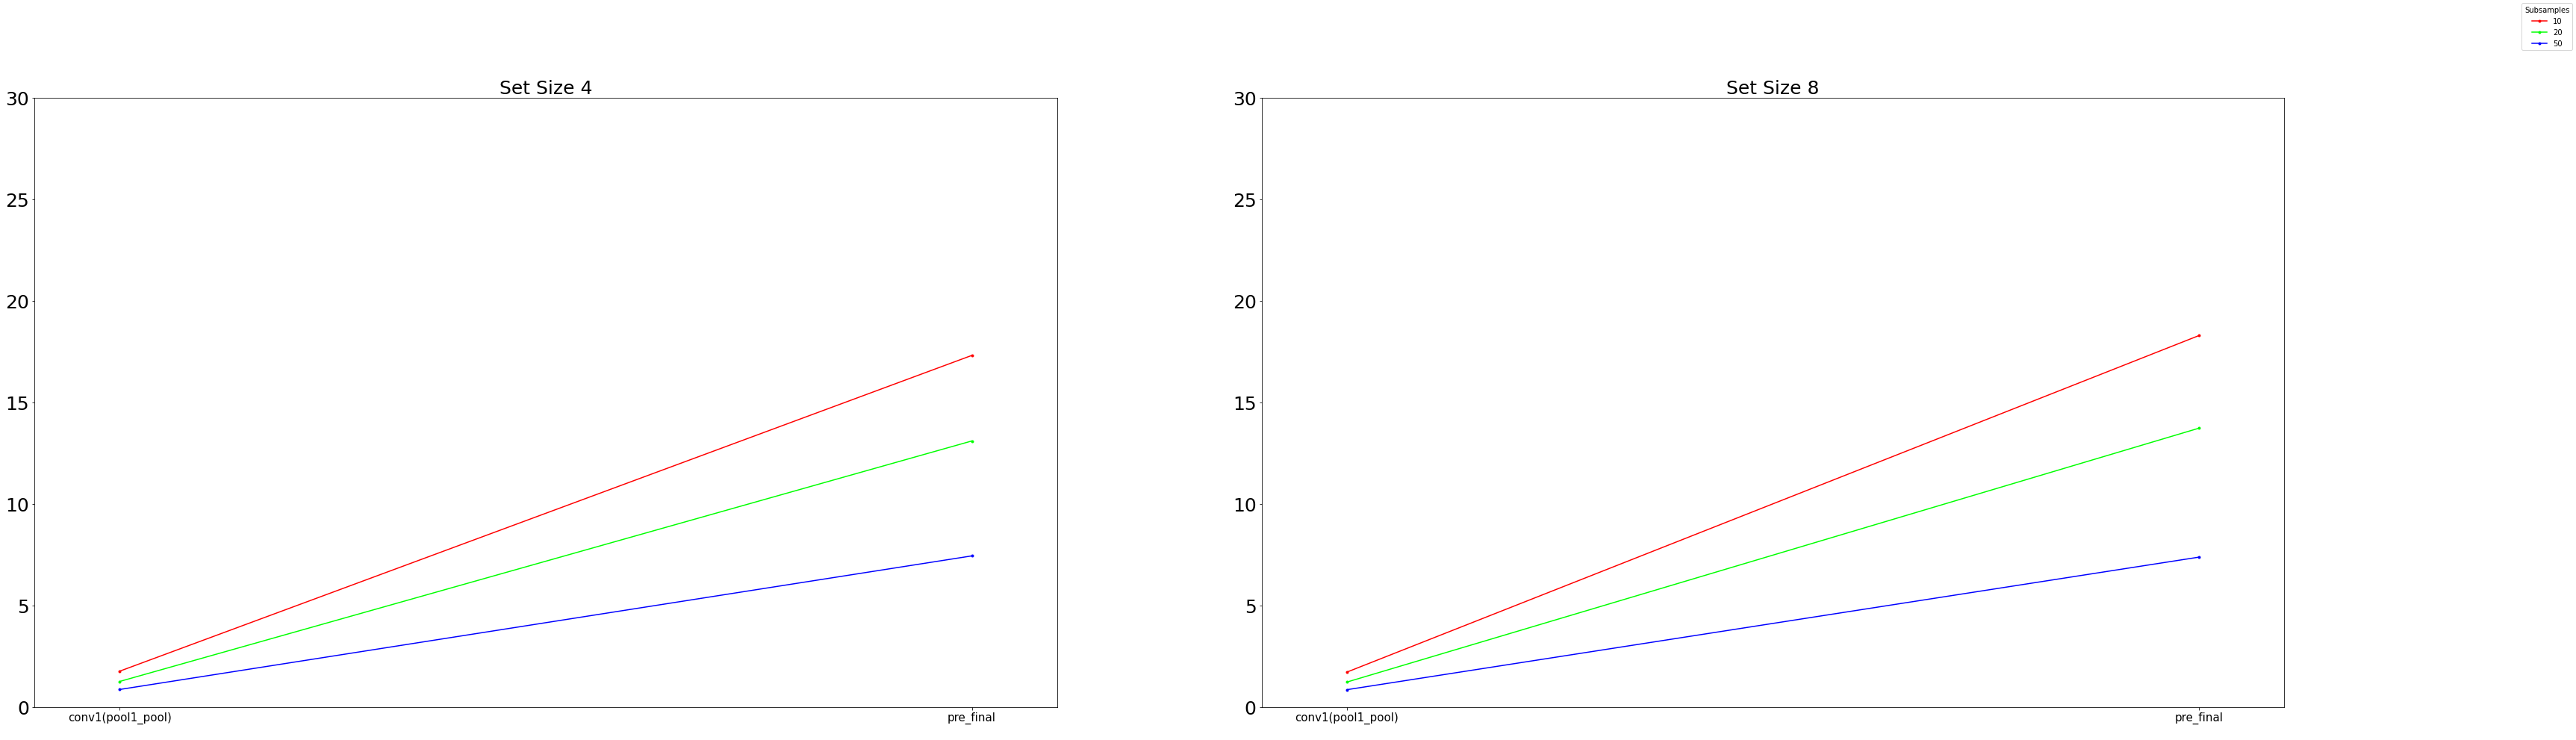

In [41]:
exp_1a_results_dir = os.path.join(RESULTS_DIR, '1a')
exp_1a_results_set_size_4 = os.path.join(exp_1a_results_dir, 'set_size_4/')
exp_1a_results_set_size_8 = os.path.join(exp_1a_results_dir, 'set_size_8/')

exp_1a_dirs_to_plot = [exp_1a_results_set_size_4, exp_1a_results_set_size_8]
fig = plot_graphs(regression_dirs = exp_1a_dirs_to_plot, fname = 'sanity_check_1a_rmspe.pkl', 
                                    plot_title = 'Individual circle size error', x_label = 'Layer Names', y_label = 'RMSPE', subsampling_levels=[10,20,50], 
                                    mode = 'avg_size', figsize = (54, 15), ylim = (0, 30), legend_title = 'Subsamples', analysis_type = 'lienar_regression', exp_name = '1a', export_df_stats = False, exp_results_dir = None)
fig

### Is the ensemble representation of average size represented by CNNs trained on naturalistic images?

In [ ]:
exp_1b_results_dir = os.path.join(RESULTS_DIR, '1b')
exp_1b_results_set_size_4 = os.path.join(exp_1b_results_dir, 'set_size_4/')
exp_1b_results_set_size_8 = os.path.join(exp_1b_results_dir, 'set_size_8/')
exp_1b_dirs_to_plot = [exp_1b_results_set_size_4, exp_1b_results_set_size_8]
fig = plot_graphs(regression_dirs = exp_1b_dirs_to_plot, fname = 'avg_size_1b.pkl', 
                                    plot_title = 'Average size error', x_label = 'Layer Names', y_label = 'RMSPE', subsampling_levels=[10,20,50], 
                                    mode = 'avg_size', figsize = (54, 15), ylim = (0, 20), legend_title = 'Subsamples',  analysis_type = 'logistic_regression', exp_name = '2a', 
                                    export_df_stats = False, exp_results_dir = None)
fig

### What happens to the individual representations in the ensemble?

In [ ]:
exp_1c_results_dir = os.path.join(RESULTS_DIR, '1c')
exp_1c_results_set_size_4 = os.path.join(exp_1c_results_dir, 'set_size_4/')
exp_1c_results_set_size_8 = os.path.join(exp_1c_results_dir, 'set_size_8/')
exp_1c_dirs_to_plot = [exp_1c_results_set_size_4, exp_1c_results_set_size_8]
fig = plot_graphs(regression_dirs = exp_1c_dirs_to_plot, fname = 'logistic_regression_1c.pkl', 
                                    plot_title = 'Logistic Regression Individual Circle', x_label = 'Layer Names', y_label = 'Accuracy', subsampling_levels=[50], 
                                    mode = 'avg_size', figsize = (54, 15), ylim = (0.5, 0.8), legend_title = 'Subsamples', analysis_type = 'logistic_regression', exp_name = '1c')
fig
